# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#!pip install split-folders

In [3]:
# Split the train dataset to get the validation dataset

# after 2 days of searching about the pythonic way to split the train set
# there are some other options like (random_split and SubsetRandomSampler) 
# the difference between them -> https://discuss.pytorch.org/72462
# https://towardsdatascience.com/pytorch-basics-sampling-samplers-2a0f29f0bf2a
# https://discuss.pytorch.org/t/using-imagefolder-random-split-with-multiple-transforms/79899

# but they have a problem as they apply image augmentation for both train and valid data and
# we only do that to the train data set

# https://www.youtube.com/watch?v=C6wbr1jJvVs
# https://pypi.org/project/split-folders/
# !pip install split-folders

import splitfolders  # or import split_folders

input_folder = '/data/landmark_images/train/'

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
#Train, val
splitfolders.ratio(input_folder, output="train_and_valid", 
                   seed=42, ratio=(.8, .2), 
                   group_prefix=None) # default values

Copying files: 4996 files [00:02, 2260.59 files/s]


In [11]:
import os
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

batch_size = 16
num_workers = 0

#normalize the color channels
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

# Transform Train dataset
train_transform = transforms.Compose([                    
                 transforms.RandomResizedCrop(224),
                 transforms.RandomRotation(degrees = (10, -10)),
                 transforms.RandomHorizontalFlip(),
                 transforms.ToTensor(),
                 normalize])

# Transform Validation dataset
valid_transform = transforms.Compose([
                  transforms.Resize((224, 224)),
                  transforms.ToTensor(),
                  normalize])

# Transform Test dataset
test_transform = transforms.Compose([
                 transforms.Resize((224, 224)),
                 transforms.ToTensor(),
                 normalize])
# Load the data in image folder
train_data  = datasets.ImageFolder('train_and_valid/train/', transform=train_transform)
val_data = datasets.ImageFolder('train_and_valid/val/',transform=valid_transform)
test_data = datasets.ImageFolder('/data/landmark_images/test',transform=test_transform)

# data loaders to create batches to be able to iterate through them
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size,
                                           num_workers= num_workers, 
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, 
                                           batch_size=batch_size,
                                           num_workers= num_workers, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data,  
                                          batch_size=batch_size, 
                                          num_workers= num_workers,
                                          shuffle=False)

loaders_scratch = {'train': train_loader,'valid': valid_loader,'test': test_loader}

**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**:
 
- I randomly split 20% of the train dataset to get the validation dataset  
- I have used Random Resized Crop by 224*224 because it was used in training imagenet and its big enough to get all the details in every image
- for data augmentation, I have used translations using Random Resized Crop, Random Horizontal Flip and random rotation by 10 degrees   to reduce overfitting

In [12]:
len(train_data), len(val_data), len(test_data)

(3996, 1000, 1250)

In [13]:
print(train_data.classes)

['00.Haleakala_National_Park', '01.Mount_Rainier_National_Park', '02.Ljubljana_Castle', '03.Dead_Sea', '04.Wroclaws_Dwarves', '05.London_Olympic_Stadium', '06.Niagara_Falls', '07.Stonehenge', '08.Grand_Canyon', '09.Golden_Gate_Bridge', '10.Edinburgh_Castle', '11.Mount_Rushmore_National_Memorial', '12.Kantanagar_Temple', '13.Yellowstone_National_Park', '14.Terminal_Tower', '15.Central_Park', '16.Eiffel_Tower', '17.Changdeokgung', '18.Delicate_Arch', '19.Vienna_City_Hall', '20.Matterhorn', '21.Taj_Mahal', '22.Moscow_Raceway', '23.Externsteine', '24.Soreq_Cave', '25.Banff_National_Park', '26.Pont_du_Gard', '27.Seattle_Japanese_Garden', '28.Sydney_Harbour_Bridge', '29.Petronas_Towers', '30.Brooklyn_Bridge', '31.Washington_Monument', '32.Hanging_Temple', '33.Sydney_Opera_House', '34.Great_Barrier_Reef', '35.Monumento_a_la_Revolucion', '36.Badlands_National_Park', '37.Atomium', '38.Forth_Bridge', '39.Gateway_of_India', '40.Stockholm_City_Hall', '41.Machu_Picchu', '42.Death_Valley_National_Pa

In [14]:
print(test_data.classes)

['00.Haleakala_National_Park', '01.Mount_Rainier_National_Park', '02.Ljubljana_Castle', '03.Dead_Sea', '04.Wroclaws_Dwarves', '05.London_Olympic_Stadium', '06.Niagara_Falls', '07.Stonehenge', '08.Grand_Canyon', '09.Golden_Gate_Bridge', '10.Edinburgh_Castle', '11.Mount_Rushmore_National_Memorial', '12.Kantanagar_Temple', '13.Yellowstone_National_Park', '14.Terminal_Tower', '15.Central_Park', '16.Eiffel_Tower', '17.Changdeokgung', '18.Delicate_Arch', '19.Vienna_City_Hall', '20.Matterhorn', '21.Taj_Mahal', '22.Moscow_Raceway', '23.Externsteine', '24.Soreq_Cave', '25.Banff_National_Park', '26.Pont_du_Gard', '27.Seattle_Japanese_Garden', '28.Sydney_Harbour_Bridge', '29.Petronas_Towers', '30.Brooklyn_Bridge', '31.Washington_Monument', '32.Hanging_Temple', '33.Sydney_Opera_House', '34.Great_Barrier_Reef', '35.Monumento_a_la_Revolucion', '36.Badlands_National_Park', '37.Atomium', '38.Forth_Bridge', '39.Gateway_of_India', '40.Stockholm_City_Hall', '41.Machu_Picchu', '42.Death_Valley_National_Pa

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

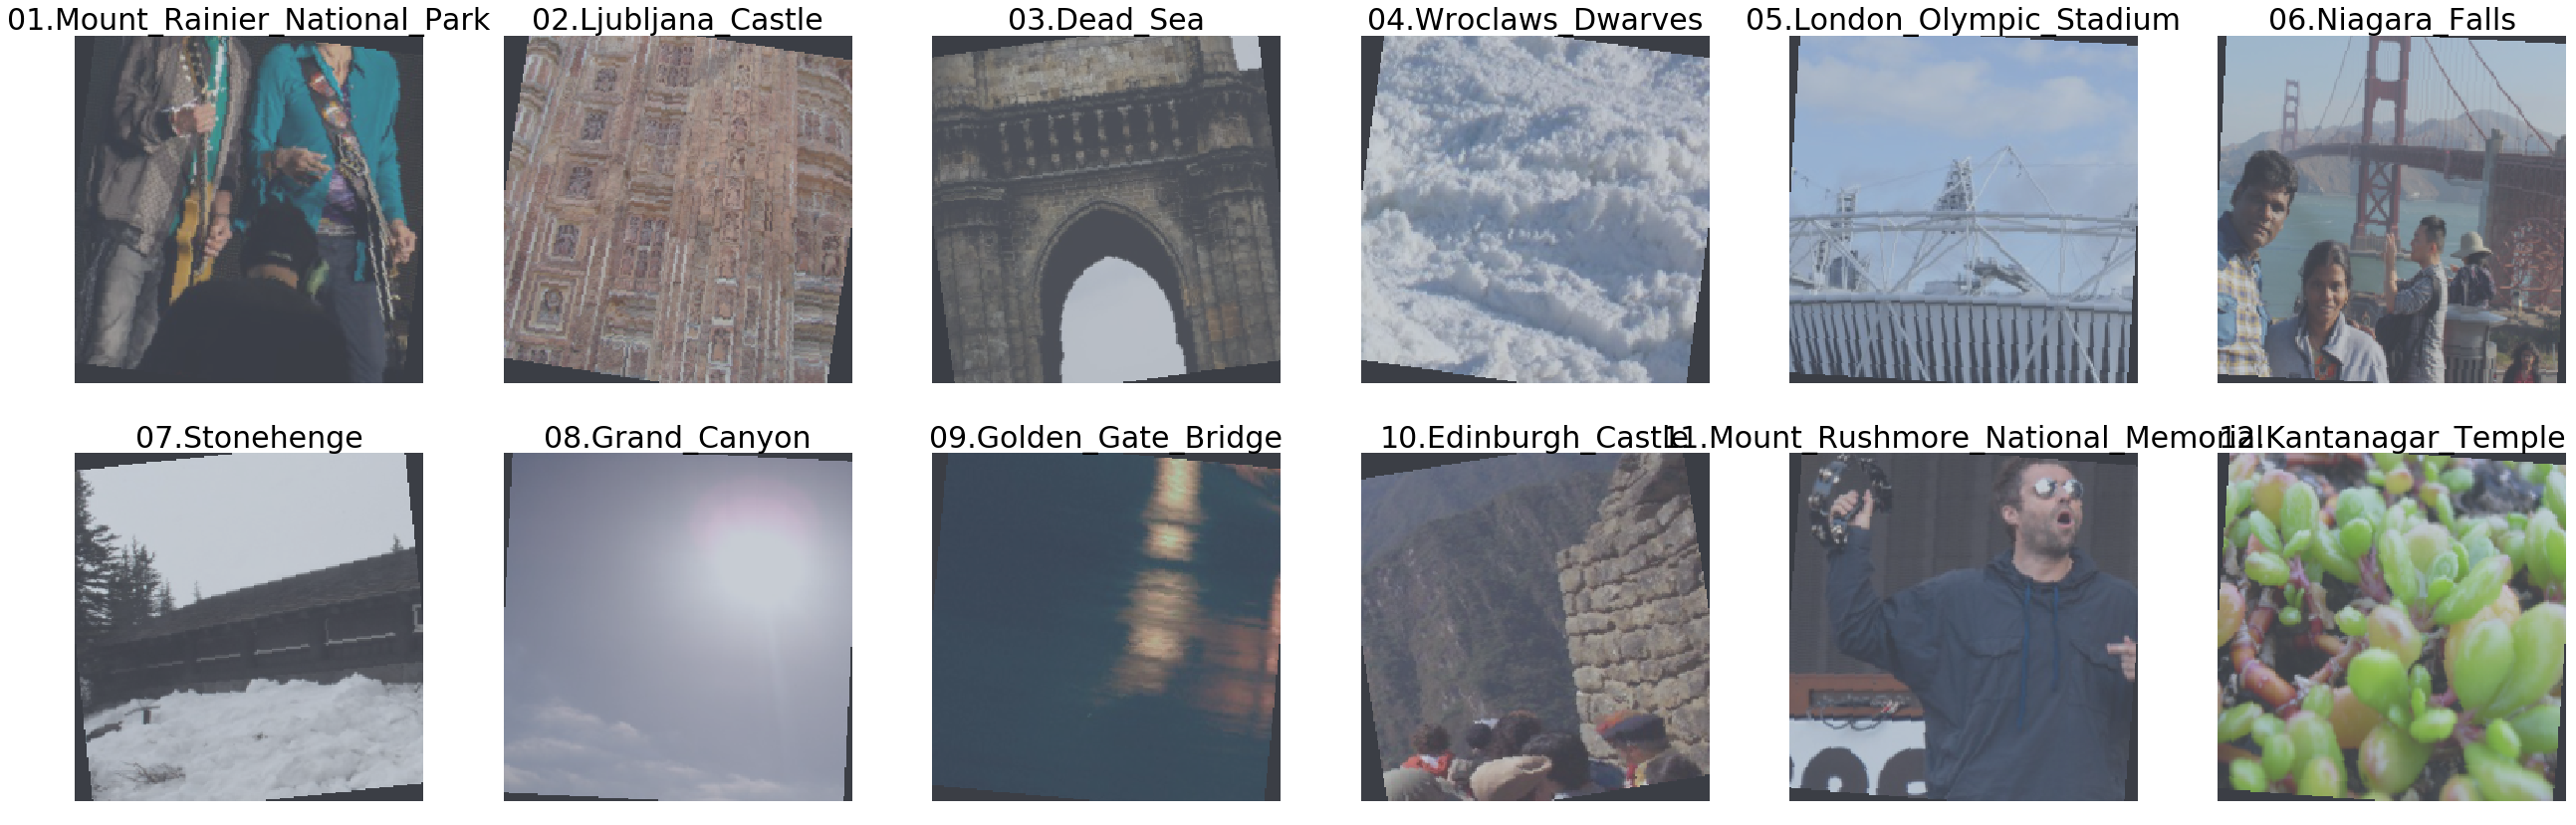

In [15]:
## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)
count_stop = 12
plt.figure(figsize=(45,45))

for i, batch in enumerate(train_loader, start=1):
    image, label = batch
    image = image / 8 + 0.5
    
    img = np.squeeze(image[0])  # reduce the unnecessary dimensions
    img = np.transpose(img, (1, 2, 0)) # transpose to standard format [height, width, channels]

    plt.subplot(6,6,i)
    plt.imshow(img)
    plt.axis('off')
    plt.title(train_data.classes[i], fontsize=30)

    if (i >= count_stop): break
plt.show()

### Initialize use_cuda variable

In [16]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [17]:
# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()

        # CNN layers
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=32)         
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=128)
        
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
       
        # MaxPooling
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully-Connected Layers
        # o = ((n-f-2p)/s) + 1
        
        self.fc1 = nn.Linear(256 * 14 * 14, 5000)
        self.bn4 = nn.BatchNorm1d(num_features=5000)        
        
        self.fc2 = nn.Linear(5000, 1000)
        self.bn5 = nn.BatchNorm1d(num_features=1000)
        
        self.fc3 = nn.Linear(1000, 500)
        self.bn6 = nn.BatchNorm1d(num_features=500)
        
        self.fc4 = nn.Linear(500, 133)
        
        # Dropout
        self.dropout = nn.Dropout(0.25)
        
        #putting it all together
    def forward(self, x):
        ## Define forward behavior                           # (1) x is the input layer
        
        x = self.max_pool(self.bn1(F.relu(self.conv1(x))))   # (2) hidden conv layer
        x = self.max_pool(self.bn2(F.relu(self.conv2(x))))   # (3) hidden conv layer
        x = self.max_pool(self.bn3(F.relu(self.conv3(x))))   # (4) hidden conv layer
        x = self.max_pool(F.relu(self.conv4(x)))             # (5) hidden conv layer

        # Fattenning inputs to Fully Connected layers
        x = x.view(-1, 256 * 14 * 14)
        
        # fully connected layers
        x = self.bn4(F.relu(self.fc1(x)))                    # (6) hidden linear layer
        x = self.dropout(x)
        x = self.bn5(F.relu(self.fc2(x)))                    # (7) hidden linear layer
        x = self.dropout(x)
        x = self.bn6(F.relu(self.fc3(x)))                    # (8) hidden linear layer
        x = self.dropout(x)
        x = self.fc4(x)                                      # (9) output layer
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  

In [18]:
print(model_scratch)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=5000, bias=True)
  (bn4): BatchNorm1d(5000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=5000, out_features=1000, bias=True)
  (bn5): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(i

I have used 4 Conv2d layers with stride=(1, 1) and padding=(1, 1) and used MaxPool by kernel_size=2 and stride=2
after each layer to create a downsampled (pooled) feature map and I have added a batch norm after the first 3 CNN layers and a batch norm after the first 3 linear layers 

Then I started the fully connected layers with droupout by 25% after each layer to reduce the over fitting

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [19]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            # set the gradients to zero
            optimizer.zero_grad()
            # the predicted outputs
            output = model(data)
            # Calculate the loss
            loss = criterion(output, target)
            # backpropagation
            loss.backward()
            # update the weights
            optimizer.step()
            # record the average training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))

        
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # record the average validation loss 
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
        
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            
            valid_loss_min = valid_loss
            
    # return trained model
    return model

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [20]:
### TODO: select loss function
criterion_scratch =  nn.CrossEntropyLoss()

### TODO: select optimizer
#optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr = 0.001)

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [21]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    
    # for every Linear layer 
    # https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch    
    if classname.find('Linear') != -1:
        # get the number of the inputs for each layer
        n = m.in_features
        
        # intialize weights from a normal distribution with mean 0 & stdv = 1.0/np.sqrt(n)
        m.weight.data.normal_(0.0, 1.0/np.sqrt(n))
        m.bias.data.fill_(0)    

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(5, loaders_scratch, model_scratch, optimizer_scratch,
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 4.900205 	Validation Loss: 4.579501
Validation loss decreased (inf --> 4.579501).  Saving model ...
Epoch: 2 	Training Loss: 4.621752 	Validation Loss: 4.332094
Validation loss decreased (4.579501 --> 4.332094).  Saving model ...
Epoch: 3 	Training Loss: 4.479023 	Validation Loss: 4.205947
Validation loss decreased (4.332094 --> 4.205947).  Saving model ...
Epoch: 4 	Training Loss: 4.342117 	Validation Loss: 4.091336
Validation loss decreased (4.205947 --> 4.091336).  Saving model ...
Epoch: 5 	Training Loss: 4.243442 	Validation Loss: 3.948473
Validation loss decreased (4.091336 --> 3.948473).  Saving model ...


### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [22]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 50 #100

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 4.784231 	Validation Loss: 4.594645
Validation loss decreased (inf --> 4.594645).  Saving model ...
Epoch: 2 	Training Loss: 4.569590 	Validation Loss: 4.404482
Validation loss decreased (4.594645 --> 4.404482).  Saving model ...
Epoch: 3 	Training Loss: 4.413035 	Validation Loss: 4.286758
Validation loss decreased (4.404482 --> 4.286758).  Saving model ...
Epoch: 4 	Training Loss: 4.312196 	Validation Loss: 4.162639
Validation loss decreased (4.286758 --> 4.162639).  Saving model ...
Epoch: 5 	Training Loss: 4.201577 	Validation Loss: 4.057045
Validation loss decreased (4.162639 --> 4.057045).  Saving model ...
Epoch: 6 	Training Loss: 4.130874 	Validation Loss: 3.972571
Validation loss decreased (4.057045 --> 3.972571).  Saving model ...
Epoch: 7 	Training Loss: 4.048510 	Validation Loss: 3.919081
Validation loss decreased (3.972571 --> 3.919081).  Saving model ...
Epoch: 8 	Training Loss: 4.001660 	Validation Loss: 3.806955
Validation loss decreased (3.91908

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [23]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))


In [24]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.408099


Test Accuracy: 42% (537/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [25]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

loaders_transfer = loaders_scratch.copy()

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [26]:
## TODO: Specify model architecture 
model_transfer=models.resnet101(pretrained=True)

# freeze the weights of resnet101 model
for param in model_transfer.parameters():
    param.requires_grad = False

# get the number of inputs for linear layer
num_features = model_transfer.fc.in_features

#change the last fully connected layer
model_transfer.fc = nn.Linear(num_features, 50)

print(model_transfer)


#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.torch/models/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:01<00:00, 91409025.73it/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  

I have used resnet101 because it performed very well on imagenet dataset

1- freeze the weights of resnet101 model   
2- get the number of inputs for linear layer   
3- change the last fully connected layer to predict the class name  

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [27]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()
## TODO: select and return optimizer
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [29]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
num_epochs= 10
model_transfer = train(num_epochs, loaders_transfer, model_transfer, optimizer_transfer, 
                      criterion_transfer, use_cuda, 'model_transfer.pt')


#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 1.670134 	Validation Loss: 1.251015
Validation loss decreased (inf --> 1.251015).  Saving model ...
Epoch: 2 	Training Loss: 1.460608 	Validation Loss: 1.148288
Validation loss decreased (1.251015 --> 1.148288).  Saving model ...
Epoch: 3 	Training Loss: 1.431030 	Validation Loss: 1.164909
Epoch: 4 	Training Loss: 1.328477 	Validation Loss: 1.118890
Validation loss decreased (1.148288 --> 1.118890).  Saving model ...
Epoch: 5 	Training Loss: 1.243306 	Validation Loss: 1.105490
Validation loss decreased (1.118890 --> 1.105490).  Saving model ...
Epoch: 6 	Training Loss: 1.244784 	Validation Loss: 1.086425
Validation loss decreased (1.105490 --> 1.086425).  Saving model ...
Epoch: 7 	Training Loss: 1.258193 	Validation Loss: 1.194991
Epoch: 8 	Training Loss: 1.189333 	Validation Loss: 1.012823
Validation loss decreased (1.086425 --> 1.012823).  Saving model ...
Epoch: 9 	Training Loss: 1.179942 	Validation Loss: 1.161169
Epoch: 10 	Training Loss: 1.180776 	Valida

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [30]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.006319


Test Accuracy: 74% (926/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [31]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

# get the class names
class_names = train_data.classes
#remove the number in the beginning of the class name
for  i,class_name in enumerate(class_names):
    class_names[i] = class_name[3:]        
    
def load_input_image(img_path):    
    img = Image.open(img_path).convert('RGB')
    transform1 = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
    
    # image tensor with the right dimension (add a batch dimension)
    img_tensor = transform1(img).unsqueeze(0)
    return img_tensor    

def predict_landmarks(img_path, k):
    # load the image and return the predicted breed
    img_tensor = load_input_image(img_path)
    
    # run on GPU if available
    if use_cuda:
        img_tensor = img_tensor.cuda()
    
    # validate the model
    model_transfer.eval()
    output = model_transfer(img_tensor)
    
    # get the top K predicted lables
    # https://discuss.pytorch.org/t/how-to-extract-probabilities/2720/9
    score, top_k_labels = torch.topk(output, k)
    top_k_labels = [class_names[x] for x in top_k_labels.cpu().numpy()[0]]
    
    return top_k_labels

# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 3)

['Golden_Gate_Bridge', 'Forth_Bridge', 'Brooklyn_Bridge']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

Is this is a picture of the

Golden_Gate_Bridge, Forth_Bridge, Brooklyn_Bridge ?


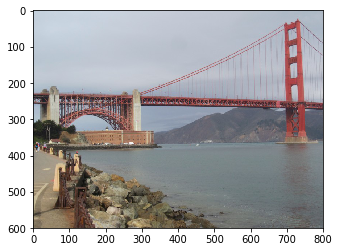

In [40]:
def suggest_locations(img_path):
    # predict the top 3 landmarks
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    img = Image.open(img_path)
    image = test_transform(img).unsqueeze(0)
    
    plt.imshow(img)
    print("Is this is a picture of the\n")
    print(*predicted_landmarks, sep = ", ",end=" "),
    print("?")
    
# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

- increase the dataset as 5000 images are small to detect the feature of 50 of landmark which have more details needed to icrease the model accurecy
- run the model for more epochs
- add more more convolutional to the nnet work but there is alimit for that to avoid unnecessary computations     -> https://qr.ae/pGmewS
- some of the images didnt include any significant mark from the landmark like it some times shows the sky and trees 
- increase the resolution in the images to get all the details.

Is this is a picture of the

Monumento_a_la_Revolucion, Vienna_City_Hall, Ljubljana_Castle ?


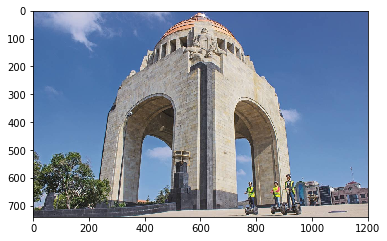

In [33]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

suggest_locations('test_images/monumento_revolucion.png')

Is this is a picture of the

Eiffel_Tower, Washington_Monument, Stockholm_City_Hall ?


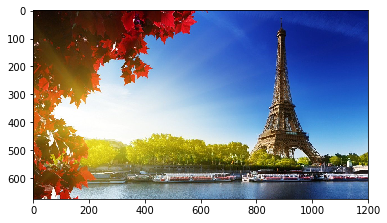

In [34]:
suggest_locations('test_images/Eiffel_Tower.png')


Is this is a picture of the

Great_Wall_of_China, Mount_Rainier_National_Park, Banff_National_Park ?


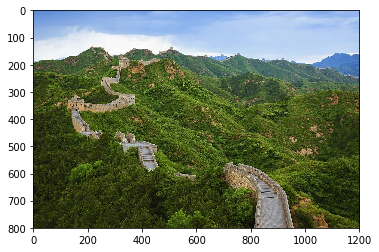

In [35]:
suggest_locations('test_images/Great-Wall-Of-China.png')


Is this is a picture of the

Machu_Picchu, Banff_National_Park, Mount_Rainier_National_Park ?


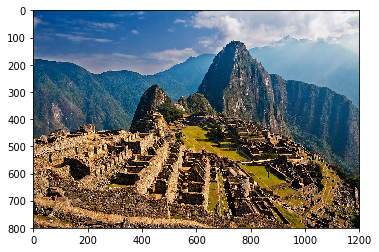

In [36]:
suggest_locations('test_images/Machu_Picchu_Peru.png')


Is this is a picture of the

Monumento_a_la_Revolucion, Vienna_City_Hall, Stockholm_City_Hall ?


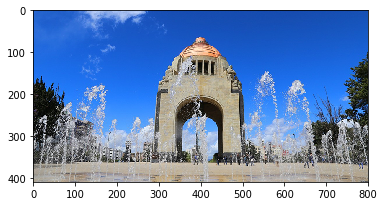

In [37]:
suggest_locations('test_images/monumento-a-la-revolucion.png')


Is this is a picture of the

Niagara_Falls, Gullfoss_Falls, Yellowstone_National_Park ?


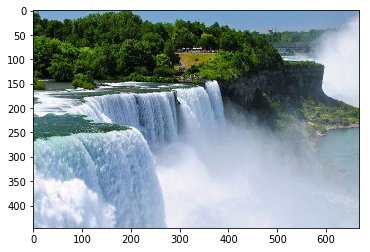

In [38]:
suggest_locations('test_images/Niagara-Falls-New-York.png')


Is this is a picture of the

Sydney_Harbour_Bridge, Sydney_Opera_House, Forth_Bridge ?


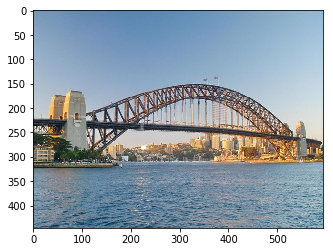

In [39]:
suggest_locations('test_images/Sydney_Harbour_Bridge.png')
